In [2]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

import mesa_helper as mh
import os
import shutil
import copy

from scipy import interpolate

%matplotlib inline

In [3]:
print(2.2*u.kg.to(u.jupiterMass))

1.159038770735926e-27


In [4]:
def read_MESAtable(filename):
    """
    read in a MESA table into an array of shape (nQ, nT, 19) = (349,121,19)
    array[:,:,-2] will be log10Q
    array[:,:,-1] will be log10rho

    Independent variables are T and Q, where logQ = logRho - 2logT + 12 (rho in [g cm^-3])
    """

    with open(filename) as f:
        for line in f:
            if len(line.split()) == 11:
                nQ = int(line.split()[7])
                nT = int(line.split()[3])

    tableData = np.zeros((nQ,nT,19))

    iQ = -1
    iT = 0
    
    with open(filename) as f:
        for line in f:
            if len(line.split()) == 1:
                iQ += 1
                log10Q = float(line.split()[0])
                        
            if len(line.split()) == 17 and line.split()[0]!='logT':
                lineList = [float(lineEntry) for lineEntry in line.split()]
                lineArr  = np.array(lineList)

                tableData[iQ,iT,:-2] = lineArr
                tableData[iQ,iT,-2] = log10Q
                tableData[iQ,iT,-1] = log10Q + 2*lineArr[0] - 12
                
                iT += 1
                if iT >= nT:
                    iT = 0


    return tableData
            

In [5]:
def format_e(n):
    a = '%E' % n
    
    firsthalf = a.split('E')[0]#.rstrip('0').rstrip('.')
    
    return firsthalf[:-1] + 'E' + a.split('E')[1]
    

In [7]:
pwd

'/Users/emily/Documents/astro/giant_planets/MESA_EoS/thermo_consistency'

In [8]:
# look at the tables (esp pure He) and try to reproduce Evan Bauer's plots
my_H = read_MESAtable("../my_MESAformat_tables/mesa-planetblend_00z100x.data")
mesaDefault_H = read_MESAtable("/Users/emily/mesa-24.08.1/data/eosDT_data/mesa-eosDT_00z100x.data")

my_He = read_MESAtable("../my_MESAformat_tables/mesa-planetblend_00z00x.data")
mesaDefault_He = read_MESAtable("/Users/emily/mesa-24.08.1/data/eosDT_data/mesa-eosDT_00z00x.data")

my_Z = read_MESAtable("../my_MESAformat_tables/mesa-planetblend_100z00x.data")

my_mixture = read_MESAtable("../my_MESAformat_tables/mesa-planetblend_00z80x.data")
mesaDefault_mixture = read_MESAtable("/Users/emily/mesa-24.08.1/data/eosDT_data/mesa-eosDT_00z80x.data")

rock = read_MESAtable("../my_MESAformat_tables/mesa-rock_100z00x.data")
h2o = read_MESAtable("../my_MESAformat_tables/mesa-h2o_100z00x.data")
iron = read_MESAtable("../my_MESAformat_tables/mesa-iron_100z00x.data")

print(np.shape(my_He))
print(np.shape(mesaDefault_He))

(349, 121, 19)
(527, 306, 19)


In [9]:
# note that the below table is already in logT, logRho format; no reparametrization from logQ necessary
mesaCMS_H = Table.read("/Users/emily/mesa-24.08.1/data/eosCMS_data/mesa-CMS_100x.data",header_start=2,data_start=3,format='ascii')
mesaCMS_He = Table.read("/Users/emily/mesa-24.08.1/data/eosCMS_data/mesa-CMS_000x.data",header_start=2,data_start=3,format='ascii')
mesaCMS_mixture = Table.read("/Users/emily/mesa-24.08.1/data/eosCMS_data/mesa-CMS_080x.data",header_start=2,data_start=3,format='ascii')
print(mesaCMS_He)
print(np.shape(mesaCMS_He))

logT logRho logPgas    logU     logS   ...  grad_ad  eta   dsp       dse   
---- ------ -------- -------- -------- ... --------- --- -------- ---------
 2.0   -8.0 1.317133 9.493576 8.683403 ... 0.4007996 0.0 1.493403 -1.669208
 2.0  -7.95 1.368426 9.493576 8.681251 ... 0.4020526 0.0 1.487127 -1.672353
 2.0   -7.9  1.41757 9.493576 8.679087 ... 0.4011862 0.0 1.492622 -1.669987
 2.0  -7.85 1.467265 9.493576 8.676906 ... 0.4008949 0.0 1.494497  -1.66908
 2.0   -7.8 1.517471 9.493576 8.674714 ... 0.4010886 0.0 1.493206 -1.669689
 2.0  -7.75 1.567528 9.493576 8.672506 ... 0.4011469 0.0 1.492879 -1.669859
 2.0   -7.7 1.617488 9.493576 8.670295 ... 0.4011072 0.0  1.49311 -1.669744
 2.0  -7.65 1.667471 9.493576 8.668072 ... 0.4010933 0.0 1.493226  -1.66969
 2.0   -7.6 1.717481 9.493576 8.665838 ... 0.4011027 0.0 1.493159 -1.669721
 2.0  -7.55  1.76748 9.493576 8.663592 ... 0.4011046 0.0 1.493158  -1.66972
 ...    ...      ...      ...      ... ...       ... ...      ...       ...
 8.0   5.55 

In [10]:
# rearrange back into a logrho, logT grid
def reshapeQTgrid(QTgrid,lower_logRho_bound,upper_logRho_bound,rounding=2):
    logT = QTgrid[0,:,0]
    logQ = QTgrid[:,0,-2]
    all_logRho = np.unique(np.round(QTgrid[:,:,-1],2))
    logRho = all_logRho[(all_logRho >= lower_logRho_bound) & (all_logRho <= upper_logRho_bound)]

    #print('logT:')
    #print(logT)
    #print('logRho:')
    #print(logRho)
    
    nT = len(logT)
    nQ = len(logQ)
    nRho = len(logRho)

    Trhogrid = np.zeros((nT,nRho,19))
    
    for i, T in enumerate(logT):
        for j, rho in enumerate(logRho):
            #print(T, rho)
            this_T_grid = QTgrid[:,i,:] # shape (349,19)
            this_Trho_subset = this_T_grid[np.round(this_T_grid[:,-1],rounding) == rho]
            #print(np.shape(this_Trho_subset))
            #print(this_Trho_subset)
            if np.shape(this_Trho_subset)[0] == 1:
                Trhogrid[i, j, :] = this_Trho_subset[0]
            else:
                Trhogrid[i, j, :] = np.nan
                Trhogrid[i, j, 0] = T
                Trhogrid[i, j, -1] = rho
            
    return Trhogrid

    

In [11]:
my_H_Trho = reshapeQTgrid(my_H,-8,6)
my_He_Trho = reshapeQTgrid(my_He,-8,6)
my_Z_Trho = reshapeQTgrid(my_Z,-8,6)
my_mixture_Trho = reshapeQTgrid(my_mixture,-8,6)

rock_Trho = reshapeQTgrid(rock,-8,6)
h2o_Trho = reshapeQTgrid(h2o,-8,6)
iron_Trho = reshapeQTgrid(iron,-8,6)

print(np.shape(my_He_Trho))
print(np.shape(my_He_Trho[0,:,:]))
print(np.shape(my_He_Trho[:,0,:]))
print(np.shape(my_He_Trho[:,:,0]))

my_He_Trho_logT = my_He_Trho[:,0,0]
print(my_He_Trho_logT)
my_He_Trho_logRho = np.unique(np.round(my_He_Trho[:,:,-1],2))
my_He_Trho_logRho = my_He_Trho_logRho[~np.isnan(my_He_Trho_logRho)]
print(my_He_Trho_logRho)

print(my_He_Trho[:,:,3])

(121, 281, 19)
(281, 19)
(121, 19)
(121, 281)
[2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65
 2.7  2.75 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35
 3.4  3.45 3.5  3.55 3.6  3.65 3.7  3.75 3.8  3.85 3.9  3.95 4.   4.05
 4.1  4.15 4.2  4.25 4.3  4.35 4.4  4.45 4.5  4.55 4.6  4.65 4.7  4.75
 4.8  4.85 4.9  4.95 5.   5.05 5.1  5.15 5.2  5.25 5.3  5.35 5.4  5.45
 5.5  5.55 5.6  5.65 5.7  5.75 5.8  5.85 5.9  5.95 6.   6.05 6.1  6.15
 6.2  6.25 6.3  6.35 6.4  6.45 6.5  6.55 6.6  6.65 6.7  6.75 6.8  6.85
 6.9  6.95 7.   7.05 7.1  7.15 7.2  7.25 7.3  7.35 7.4  7.45 7.5  7.55
 7.6  7.65 7.7  7.75 7.8  7.85 7.9  7.95 8.  ]
[-8.   -7.95 -7.9  -7.85 -7.8  -7.75 -7.7  -7.65 -7.6  -7.55 -7.5  -7.45
 -7.4  -7.35 -7.3  -7.25 -7.2  -7.15 -7.1  -7.05 -7.   -6.95 -6.9  -6.85
 -6.8  -6.75 -6.7  -6.65 -6.6  -6.55 -6.5  -6.45 -6.4  -6.35 -6.3  -6.25
 -6.2  -6.15 -6.1  -6.05 -6.   -5.95 -5.9  -5.85 -5.8  -5.75 -5.7  -5.65
 -5.6  -5.55 -5.5  -5.45 -5.4  -5.35 -5.3  -5.2

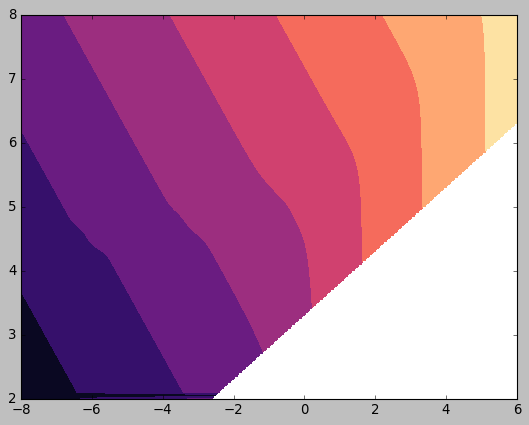

In [12]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

ax.contourf(my_He_Trho[:,:,-1], my_He_Trho[:,:,0], my_He_Trho[:,:,1], cmap='magma')
ax.set_xlim(-8,6)
ax.set_ylim(2,8)
plt.show()

In [13]:
mesaDefault_H_Trho = reshapeQTgrid(mesaDefault_H,-3,3,rounding=3)
mesaDefault_He_Trho = reshapeQTgrid(mesaDefault_He,-3,3,rounding=3)
mesaDefault_mixture_Trho = reshapeQTgrid(mesaDefault_mixture,-3,3,rounding=3)

In [14]:
print(np.shape(mesaDefault_He_Trho))
print(np.shape(mesaDefault_He_Trho[0,:,:]))
print(np.shape(mesaDefault_He_Trho[:,0,:]))
print(np.shape(mesaDefault_He_Trho[:,:,0]))

mesaDefault_He_Trho_logT = mesaDefault_He_Trho[:,0,0]
print(mesaDefault_He_Trho_logT)
mesaDefault_He_Trho_logRho = np.unique(np.round(mesaDefault_He_Trho[:,:,-1],2))
mesaDefault_He_Trho_logRho = mesaDefault_He_Trho_logRho[~np.isnan(mesaDefault_He_Trho_logRho)]
print(mesaDefault_He_Trho_logRho)

print(mesaDefault_He_Trho[:,:,-1])

(306, 601, 19)
(601, 19)
(306, 19)
(306, 601)
[2.1  2.12 2.14 2.16 2.18 2.2  2.22 2.24 2.26 2.28 2.3  2.32 2.34 2.36
 2.38 2.4  2.42 2.44 2.46 2.48 2.5  2.52 2.54 2.56 2.58 2.6  2.62 2.64
 2.66 2.68 2.7  2.72 2.74 2.76 2.78 2.8  2.82 2.84 2.86 2.88 2.9  2.92
 2.94 2.96 2.98 3.   3.02 3.04 3.06 3.08 3.1  3.12 3.14 3.16 3.18 3.2
 3.22 3.24 3.26 3.28 3.3  3.32 3.34 3.36 3.38 3.4  3.42 3.44 3.46 3.48
 3.5  3.52 3.54 3.56 3.58 3.6  3.62 3.64 3.66 3.68 3.7  3.72 3.74 3.76
 3.78 3.8  3.82 3.84 3.86 3.88 3.9  3.92 3.94 3.96 3.98 4.   4.02 4.04
 4.06 4.08 4.1  4.12 4.14 4.16 4.18 4.2  4.22 4.24 4.26 4.28 4.3  4.32
 4.34 4.36 4.38 4.4  4.42 4.44 4.46 4.48 4.5  4.52 4.54 4.56 4.58 4.6
 4.62 4.64 4.66 4.68 4.7  4.72 4.74 4.76 4.78 4.8  4.82 4.84 4.86 4.88
 4.9  4.92 4.94 4.96 4.98 5.   5.02 5.04 5.06 5.08 5.1  5.12 5.14 5.16
 5.18 5.2  5.22 5.24 5.26 5.28 5.3  5.32 5.34 5.36 5.38 5.4  5.42 5.44
 5.46 5.48 5.5  5.52 5.54 5.56 5.58 5.6  5.62 5.64 5.66 5.68 5.7  5.72
 5.74 5.76 5.78 5.8  5.82 5.84 5.

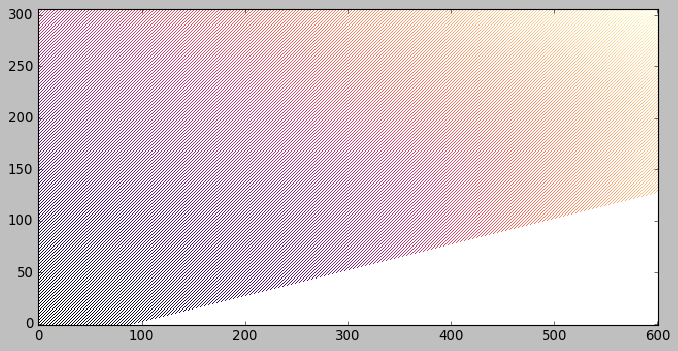

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

#ax.contourf(mesaDefault_He_Trho[:,:,-1], mesaDefault_He_Trho[:,:,0], mesaDefault_He_Trho[:,:,2], cmap='magma')
ax.imshow(mesaDefault_He_Trho[:,:,1],cmap='magma',origin='lower',interpolation='none')
#ax.set_xlim(-8,6)
#ax.set_ylim(2,8)
plt.show()

In [16]:
# So reshaping the MESA grid back into logRho, logT space is annoying, because given del log Q = 0.03, del logT = 0.02, there is no easy choice
# of spacing del log rho where every point is defined. I think the easiest (but probably comp. expensive) way to solve this is by interpolating the MESA table before
# doing the reshaping step.
def resample_MESA_QTgrid(QTgrid, new_dellogQ=0.05, new_dellogT=0.05):
    logT = QTgrid[0,:,0]
    logQ = QTgrid[:,0,-2]

    #print(len(logQ),len(logT))
    
    new_logT = np.arange(logT[0], logT[-1] + new_dellogT, new_dellogT)
    new_logQ = np.arange(logQ[0], logQ[-1] + new_dellogQ, new_dellogQ)
    new_logT_grid, new_logQ_grid = np.meshgrid(new_logT, new_logQ)
    #print(len(new_logQ),len(new_logT))
    new_QTgrid = np.zeros((len(new_logQ), len(new_logT), 19))

    for i in range(19):
        interp_attr_given_QT = interpolate.RegularGridInterpolator(points=(logQ, logT), values=QTgrid[:,:,i], bounds_error=False, fill_value=None, method='slinear')
        new_QTgrid[:,:,i] = interp_attr_given_QT((new_logQ_grid, new_logT_grid))
        
    return new_QTgrid


In [17]:
mesaDefault_H_resampled = resample_MESA_QTgrid(mesaDefault_H)

mesaDefault_He_resampled = resample_MESA_QTgrid(mesaDefault_He)

mesaDefault_mixture_resampled = resample_MESA_QTgrid(mesaDefault_mixture)

In [20]:
mesaDefault_H_resampled_Trho = reshapeQTgrid(mesaDefault_H_resampled,-8,6,rounding=2)
mesaDefault_He_resampled_Trho = reshapeQTgrid(mesaDefault_He_resampled,-8,6,rounding=2)
mesaDefault_mixture_resampled_Trho = reshapeQTgrid(mesaDefault_mixture_resampled,-8,6,rounding=2)
print(np.shape(mesaDefault_He_resampled_Trho))

(123, 280, 19)


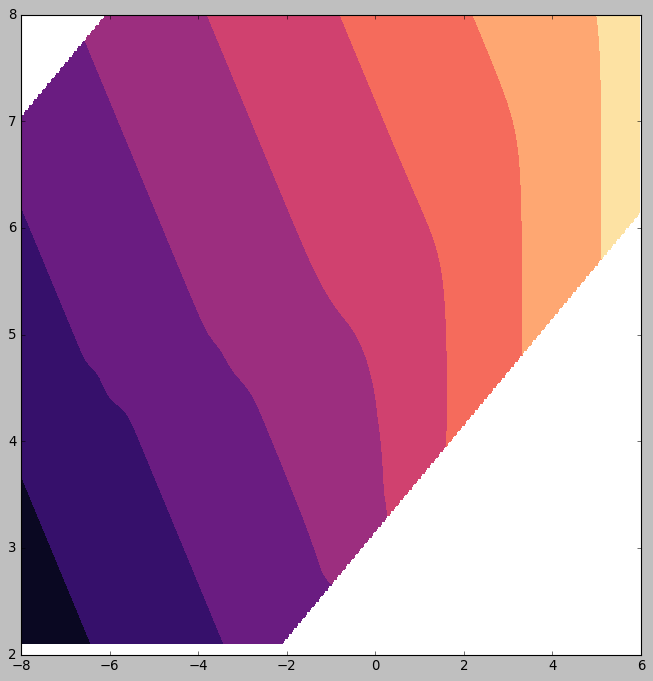

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.contourf(mesaDefault_He_resampled_Trho[:,:,-1], mesaDefault_He_resampled_Trho[:,:,0], mesaDefault_He_resampled_Trho[:,:,1], cmap='magma')

ax.set_xlim(-8,6)
ax.set_ylim(2,8)
plt.show()

In [22]:
# reshape MESA CMS table, which is already in T, rho form, into shape (nT, nRho, 19).
def reshape_mesaCMS(mesaCMS):
    logT = np.array(np.unique(mesaCMS['logT']))
    logrho = np.array(np.unique(mesaCMS['logRho']))
    #print(logT, logrho)
    new_mesaCMS = np.zeros((len(logT),len(logrho),19))
    for i in range(len(logrho)):
        new_mesaCMS[:,i,0] = logT
    for j in range(len(logT)):
        new_mesaCMS[j,:,-1] = logrho

    eoskeys = ['logPgas', 'logU', 'logS', 'chiRho', 'chiT', 'Cp', 'Cv', 'dE_dRho', 'dS_dT', 'dS_dRho', 'mu', 'lnfree_e', 'gamma1', 'gamma3', 'grad_ad', 'eta']
    for k,key in enumerate(eoskeys):
        attr_Trho_grid = np.zeros((len(logT), len(logrho)))
        for j in range(len(logT)):
            attr_Trho_grid[j] = mesaCMS[key][j*len(logrho): (j+1)*len(logrho)]
        new_mesaCMS[:,:,k+1] = attr_Trho_grid

    new_mesaCMS[:,:,-2] = new_mesaCMS[:,:,-1] - 2*new_mesaCMS[:,:,0] + 12

    return new_mesaCMS

In [23]:
mesaCMS_H_Trho_full = reshape_mesaCMS(mesaCMS_H)
mesaCMS_H_Trho = mesaCMS_H_Trho_full#[:,100:221,:]
print(np.shape(mesaCMS_H_Trho))

mesaCMS_He_Trho_full = reshape_mesaCMS(mesaCMS_He)
mesaCMS_He_Trho = mesaCMS_He_Trho_full#[:,100:221,:]
print(np.shape(mesaCMS_He_Trho))

mesaCMS_mixture_Trho_full = reshape_mesaCMS(mesaCMS_mixture)
mesaCMS_mixture_Trho = mesaCMS_mixture_Trho_full#[:,100:221,:]

(121, 281, 19)
(121, 281, 19)


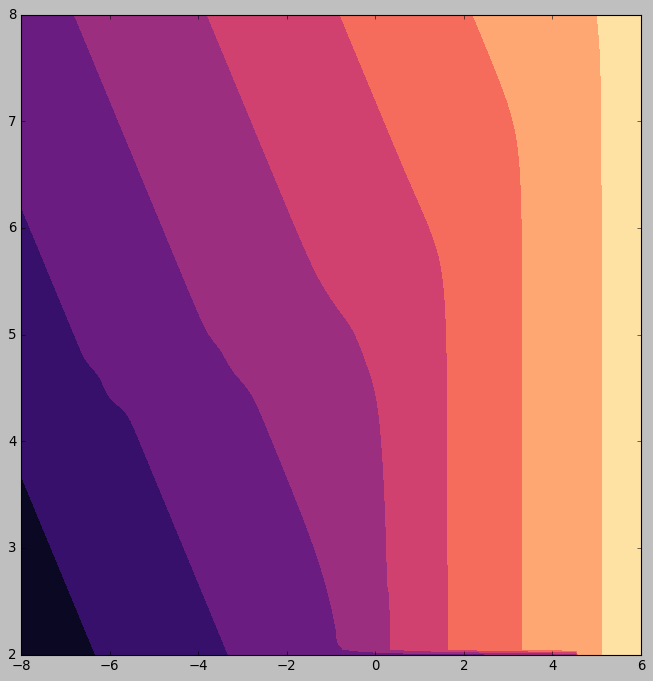

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.contourf(mesaCMS_He_Trho[:,:,-1], mesaCMS_He_Trho[:,:,0], mesaCMS_He_Trho[:,:,1], cmap='magma')

ax.set_xlim(-8,6)
ax.set_ylim(2,8)
plt.show()

In [26]:
#okay! looks good.
# next:
# calculate thermodynamic consistency metrics dpe, dse, dsp on this grid (see MESA V sec. A.1.3 eq 48)

# ingredients: rho, p, T, finite diff quantities

In [38]:
def consistency_metrics(rhoTgrid, plot=True, eosname=''):
    """
    assumes grid of shape (nT,nRho,19)
    """
    nT, nrho = np.shape(rhoTgrid[:,:,0])

    grid_T = rhoTgrid[:,:,0][:,0]
    grid_rho = rhoTgrid[:,:,-1][0]
    
    between_T = grid_T[:-1] + 0.5*(grid_T[1:] - grid_T[:-1])
    between_rho = grid_rho[:-1] + 0.5*(grid_rho[1:] - grid_rho[:-1])

    meshgrid_T, meshgrid_rho = np.meshgrid(grid_T, grid_rho, indexing='ij')
    
    dP_dT_rho_between_grid_points = np.zeros((nT-1, nrho))
    dE_dT_rho_between_grid_points = np.zeros((nT-1, nrho))
    dS_dT_rho_between_grid_points = np.zeros((nT-1, nrho))
    
    for i in range(nT - 1):
        #print(rhoTgrid[:,:,0][i])
        dP_dT_rho_between_grid_points[i] = (rhoTgrid[:,:,1][i+1] - rhoTgrid[:,:,1][i])/(rhoTgrid[:,:,0][i+1] - rhoTgrid[:,:,0][i])
        dE_dT_rho_between_grid_points[i] = (rhoTgrid[:,:,2][i+1] - rhoTgrid[:,:,2][i])/(rhoTgrid[:,:,0][i+1] - rhoTgrid[:,:,0][i])
        dS_dT_rho_between_grid_points[i] = (rhoTgrid[:,:,3][i+1] - rhoTgrid[:,:,3][i])/(rhoTgrid[:,:,0][i+1] - rhoTgrid[:,:,0][i])

    dP_dT_rho_between_grid_points[~np.isfinite(dP_dT_rho_between_grid_points)] = 0.
    dE_dT_rho_between_grid_points[~np.isfinite(dE_dT_rho_between_grid_points)] = 0.
    dS_dT_rho_between_grid_points[~np.isfinite(dS_dT_rho_between_grid_points)] = 0.
    
    interp_dP_dT_rho = interpolate.RegularGridInterpolator(points=(between_T, grid_rho), values=dP_dT_rho_between_grid_points, bounds_error=False, fill_value=None, method='slinear')
    # convert dlnP/dlnT to dP/dT
    dP_dT_rho = interp_dP_dT_rho((meshgrid_T,meshgrid_rho)) * (10**rhoTgrid[:,:,1]/10**rhoTgrid[:,:,0])

    interp_dE_dT_rho = interpolate.RegularGridInterpolator(points=(between_T, grid_rho), values=dE_dT_rho_between_grid_points, bounds_error=False, fill_value=None, method='slinear')
    dE_dT_rho = interp_dE_dT_rho((meshgrid_T,meshgrid_rho)) * (10**rhoTgrid[:,:,2]/10**rhoTgrid[:,:,0])

    interp_dS_dT_rho = interpolate.RegularGridInterpolator(points=(between_T, grid_rho), values=dS_dT_rho_between_grid_points, bounds_error=False, fill_value=None, method='slinear')
    dS_dT_rho = interp_dS_dT_rho((meshgrid_T,meshgrid_rho)) * (10**rhoTgrid[:,:,3]/10**rhoTgrid[:,:,0])

    '''
    fig, axes = plt.subplots(1,3,figsize=(24,6))
        
    divider0 = make_axes_locatable(axes[0])
    cax0 = divider0.append_axes('right', size='5%', pad=0.05)
    cs0 = axes[0].pcolormesh(meshgrid_rho, meshgrid_T, np.log10(dP_dT_rho), cmap='magma', shading='nearest')
    fig.colorbar(cs0, cax=cax0, orientation='vertical',label='dP_dT_rho')

    divider1 = make_axes_locatable(axes[1])
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cs1 = axes[1].pcolormesh(meshgrid_rho, meshgrid_T, np.log10(dE_dT_rho), cmap='magma', shading='nearest')
    fig.colorbar(cs1, cax=cax1, orientation='vertical',label='dE_dT_rho')

    divider2 = make_axes_locatable(axes[2])
    cax2 = divider2.append_axes('right', size='5%', pad=0.05)
    cs2 = axes[2].pcolormesh(meshgrid_rho, meshgrid_T, np.log10(dS_dT_rho), cmap='magma', shading='nearest')
    fig.colorbar(cs2, cax=cax2, orientation='vertical',label='dS_dT_rho')
    
    for ax in axes:
        ax.set_xlim(-3,3)
        ax.set_ylim(3.,6.5)
    plt.show()
    '''   
    

    dE_drho_T_between_grid_points = np.zeros((nT, nrho-1))
    dS_drho_T_between_grid_points = np.zeros((nT, nrho-1))
    for j in range(nrho - 1):
        #print(rhoTgrid[:,:,-1][:,j])
        dE_drho_T_between_grid_points[:,j] = (rhoTgrid[:,:,2][:,j+1] - rhoTgrid[:,:,2][:,j])/(rhoTgrid[:,:,-1][:,j+1] - rhoTgrid[:,:,-1][:,j])
        dS_drho_T_between_grid_points[:,j] = (rhoTgrid[:,:,3][:,j+1] - rhoTgrid[:,:,3][:,j])/(rhoTgrid[:,:,-1][:,j+1] - rhoTgrid[:,:,-1][:,j])
    
    dE_drho_T_between_grid_points[~np.isfinite(dE_drho_T_between_grid_points)] = 0.
    dS_drho_T_between_grid_points[~np.isfinite(dS_drho_T_between_grid_points)] = 0.

    interp_dE_drho_T = interpolate.RegularGridInterpolator(points=(grid_T, between_rho), values=dE_drho_T_between_grid_points, bounds_error=False, fill_value=None, method='slinear')
    dE_drho_T = interp_dE_drho_T((meshgrid_T,meshgrid_rho)) * (10**rhoTgrid[:,:,2]/10**rhoTgrid[:,:,-1])

    interp_dS_drho_T = interpolate.RegularGridInterpolator(points=(grid_T, between_rho), values=dS_drho_T_between_grid_points, bounds_error=False, fill_value=None, method='slinear')
    dS_drho_T = interp_dS_drho_T((meshgrid_T,meshgrid_rho)) * (10**rhoTgrid[:,:,3]/10**rhoTgrid[:,:,-1])

    '''
    fig, axes = plt.subplots(1,2,figsize=(16,6))
        
    divider0 = make_axes_locatable(axes[0])
    cax0 = divider0.append_axes('right', size='5%', pad=0.05)
    cs0 = axes[0].pcolormesh(meshgrid_rho, meshgrid_T, dE_drho_T, cmap='magma', shading='nearest')
    fig.colorbar(cs0, cax=cax0, orientation='vertical',label='dE_drho_T')

    divider1 = make_axes_locatable(axes[1])
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cs1 = axes[1].pcolormesh(meshgrid_rho, meshgrid_T, dS_drho_T, cmap='magma', shading='nearest')
    fig.colorbar(cs1, cax=cax1, orientation='vertical',label='dS_drho_T')

    for ax in axes:
        ax.set_xlim(-3,3)
        ax.set_ylim(3.,6.5)
    plt.show()
    '''
    '''
    # dpe terms
    fig, axes = plt.subplots(1,4,figsize=(32,6))
        
    divider0 = make_axes_locatable(axes[0])
    cax0 = divider0.append_axes('right', size='5%', pad=0.05)
    cs0 = axes[0].pcolormesh(meshgrid_rho, meshgrid_T, ((10**rhoTgrid[:,:,-1])**2/(10**rhoTgrid[:,:,1])), cmap='magma', shading='nearest')
    fig.colorbar(cs0, cax=cax0, orientation='vertical',label='rho^2/P')

    divider1 = make_axes_locatable(axes[1])
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cs1 = axes[1].pcolormesh(meshgrid_rho, meshgrid_T, dE_drho_T, cmap='magma', shading='nearest')
    fig.colorbar(cs1, cax=cax1, orientation='vertical',label='dE_drho_T')

    divider2 = make_axes_locatable(axes[2])
    cax2 = divider2.append_axes('right', size='5%', pad=0.05)
    cs2 = axes[2].pcolormesh(meshgrid_rho, meshgrid_T, (10**rhoTgrid[:,:,0]/10**rhoTgrid[:,:,1]), cmap='magma', shading='nearest')
    fig.colorbar(cs2, cax=cax2, orientation='vertical',label='T/P')
    
    divider3 = make_axes_locatable(axes[3])
    cax3 = divider3.append_axes('right', size='5%', pad=0.05)
    cs3 = axes[3].pcolormesh(meshgrid_rho, meshgrid_T, dP_dT_rho, cmap='magma', shading='nearest')
    fig.colorbar(cs3, cax=cax3, orientation='vertical',label='dP_dT_rho')

    for ax in axes:
        ax.set_xlim(-3,3)
        ax.set_ylim(3.,6.5)
    plt.show()

    '''    
    dpe = ((10**rhoTgrid[:,:,-1])**2/(10**rhoTgrid[:,:,1]))*dE_drho_T + (10**rhoTgrid[:,:,0]/10**rhoTgrid[:,:,1])*dP_dT_rho - 1
    dse = 10**rhoTgrid[:,:,0] * (dS_dT_rho/dE_dT_rho) - 1
    dsp = -(10**rhoTgrid[:,:,-1])**2 * (dS_drho_T/dP_dT_rho) - 1

    if plot is True:
        cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
        cmap.set_over('red')
        cmap.set_under('black')
        cmap.set_bad('grey')
        fig, axes = plt.subplots(1,3,figsize=(24,6))
        
        divider0 = make_axes_locatable(axes[0])
        cax0 = divider0.append_axes('right', size='5%', pad=0.05)
        cs0 = axes[0].pcolormesh(meshgrid_rho, meshgrid_T, np.log10(np.abs(dpe)), cmap=cmap, shading='nearest',vmin=-7,vmax=0)
        fig.colorbar(cs0, cax=cax0, orientation='vertical',label=r'$\log_{10}{\mathrm{dpe}}$')

        divider1 = make_axes_locatable(axes[1])
        cax1 = divider1.append_axes('right', size='5%', pad=0.05)
        cs1 = axes[1].pcolormesh(meshgrid_rho, meshgrid_T, np.log10(np.abs(dse)), cmap=cmap, shading='nearest',vmin=-7,vmax=0)
        fig.colorbar(cs1, cax=cax1, orientation='vertical',label=r'$\log_{10}{\mathrm{dse}}$')

        divider2 = make_axes_locatable(axes[2])
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        cs2 = axes[2].pcolormesh(meshgrid_rho, meshgrid_T, np.log10(np.abs(dsp)), cmap=cmap, shading='nearest',vmin=-7,vmax=0)
        fig.colorbar(cs2, cax=cax2, orientation='vertical',label=r'$\log_{10}{\mathrm{dsp}}$')
    
        for ax in axes:
            ax.set_xlim(-8,6)
            ax.set_ylim(2,8)
            ax.set_xlabel(r'$\log_{10}{\rho}$',fontsize=20)
        axes[0].set_ylabel(r'$\log_{10}{T}$',fontsize=20)
        axes[0].set_title('{0} '.format(eosname)+r'$\log_{10}{\mathrm{dpe}}$',fontsize=20)
        axes[1].set_title('{0} '.format(eosname)+r'$\log_{10}{\mathrm{dse}}$',fontsize=20)
        axes[2].set_title('{0} '.format(eosname)+r'$\log_{10}{\mathrm{dsp}}$',fontsize=20)
        plt.show()
            
    return dpe, dse, dsp
    

# plot and compare to EB's plots

## Hydrogen

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/432129624.py:129: RuntimeWarning: divide by zero encountered in divide
  dse = 10**rhoTgrid[:,:,0] * (dS_dT_rho/dE_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/432129624.py:130: RuntimeWarning: divide by zero encountered in divide
  dsp = -(10**rhoTgrid[:,:,-1])**2 * (dS_drho_T/dP_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/432129624.py:130: RuntimeWarning: invalid value encountered in divide
  dsp = -(10**rhoTgrid[:,:,-1])**2 * (dS_drho_T/dP_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/432129624.py:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))


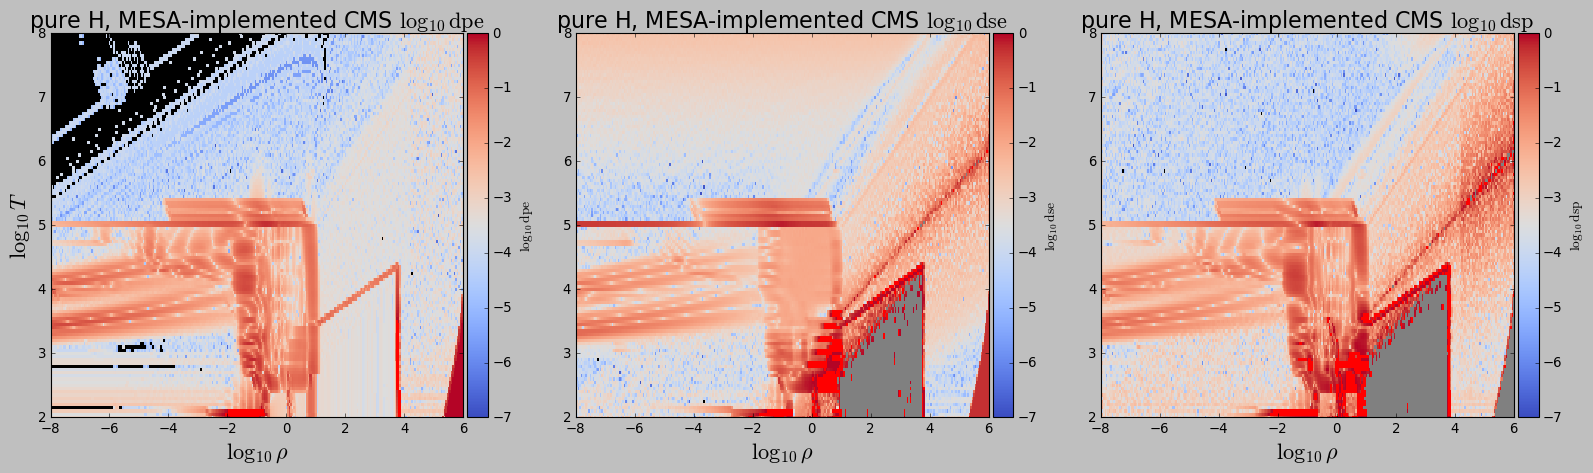

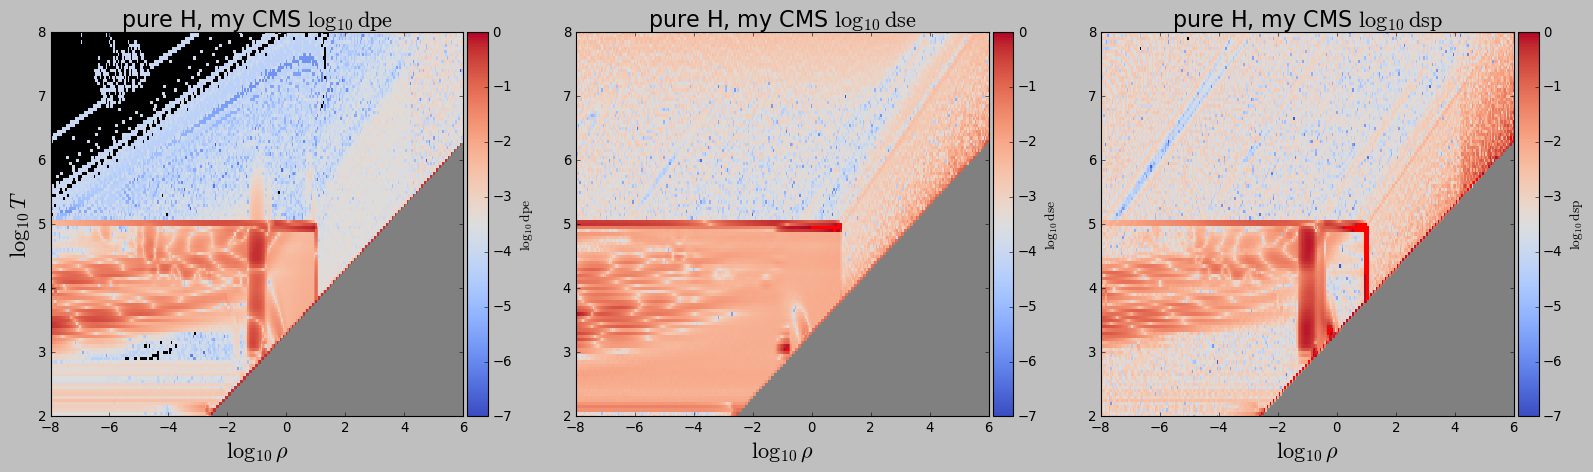

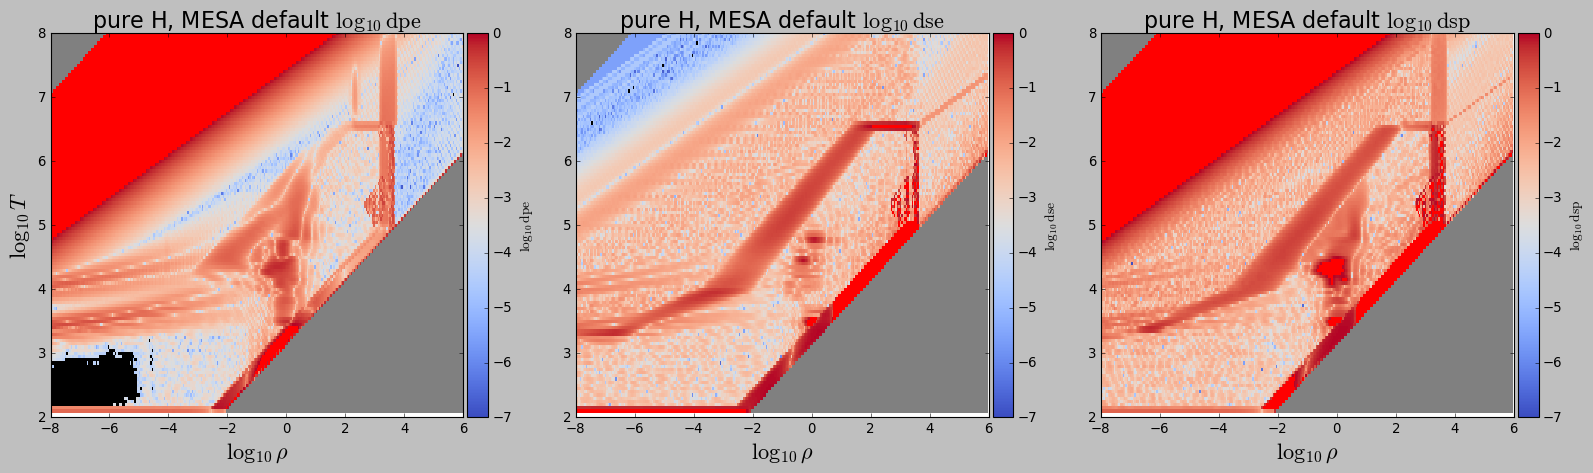

In [39]:
dpe, dse, dsp = consistency_metrics(mesaCMS_H_Trho,eosname='pure H, MESA-implemented CMS')
dpe, dse, dsp = consistency_metrics(my_H_Trho,eosname='pure H, my CMS')
dpe, dse, dsp = consistency_metrics(mesaDefault_H_resampled_Trho,eosname='pure H, MESA default')

## Helium

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:129: RuntimeWarning: divide by zero encountered in divide
  dse = 10**rhoTgrid[:,:,0] * (dS_dT_rho/dE_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:130: RuntimeWarning: divide by zero encountered in divide
  dsp = -(10**rhoTgrid[:,:,-1])**2 * (dS_drho_T/dP_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))


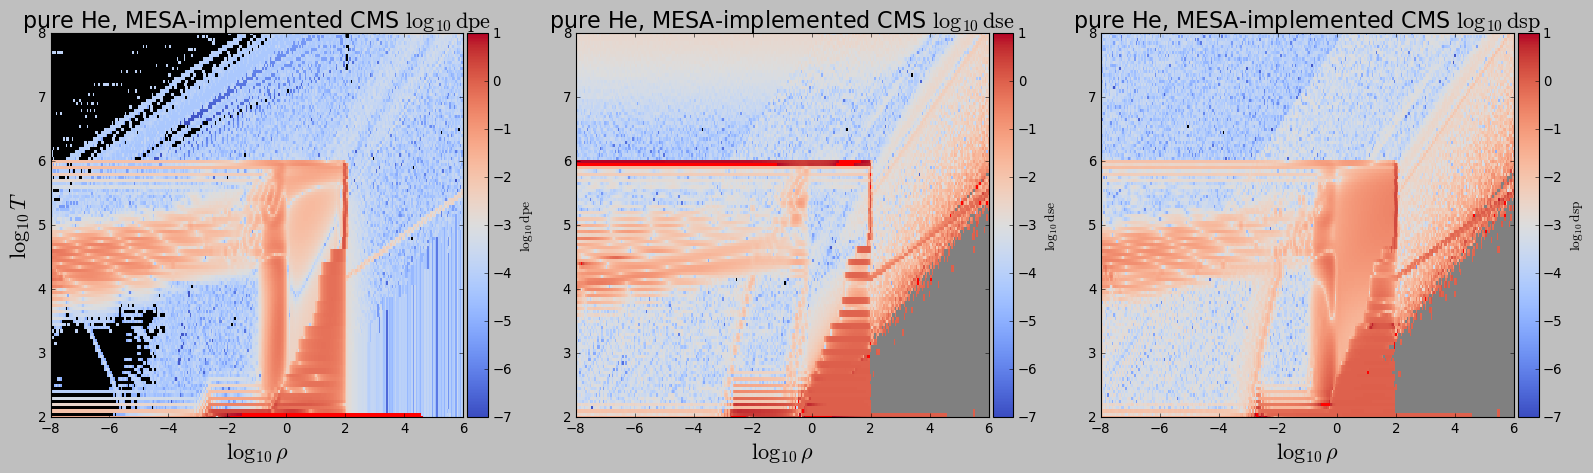

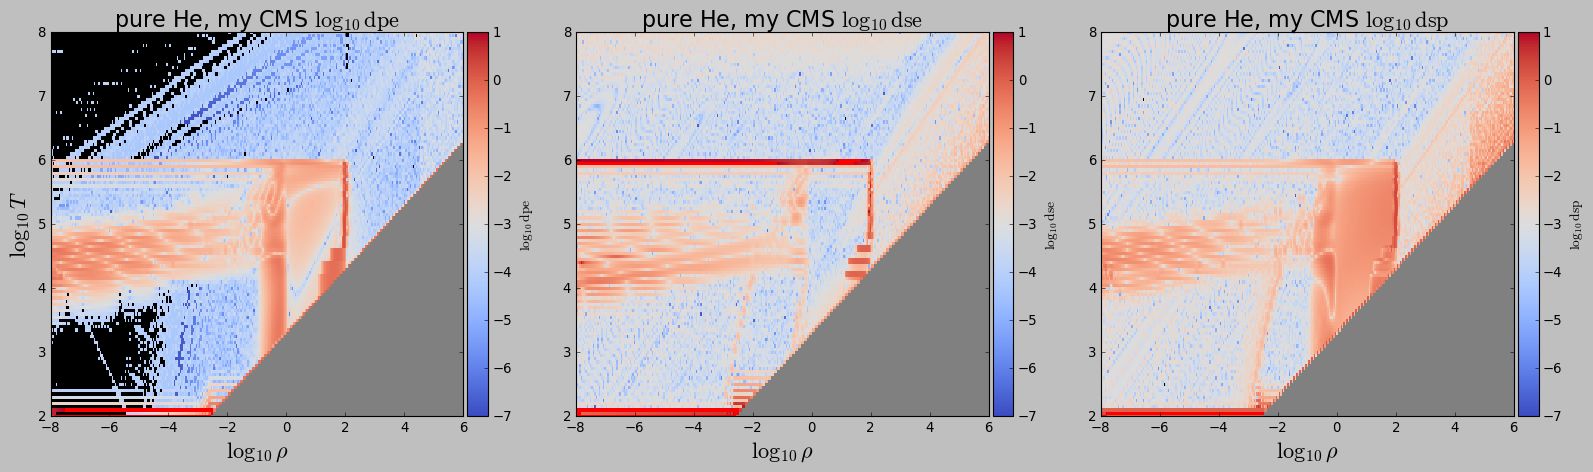

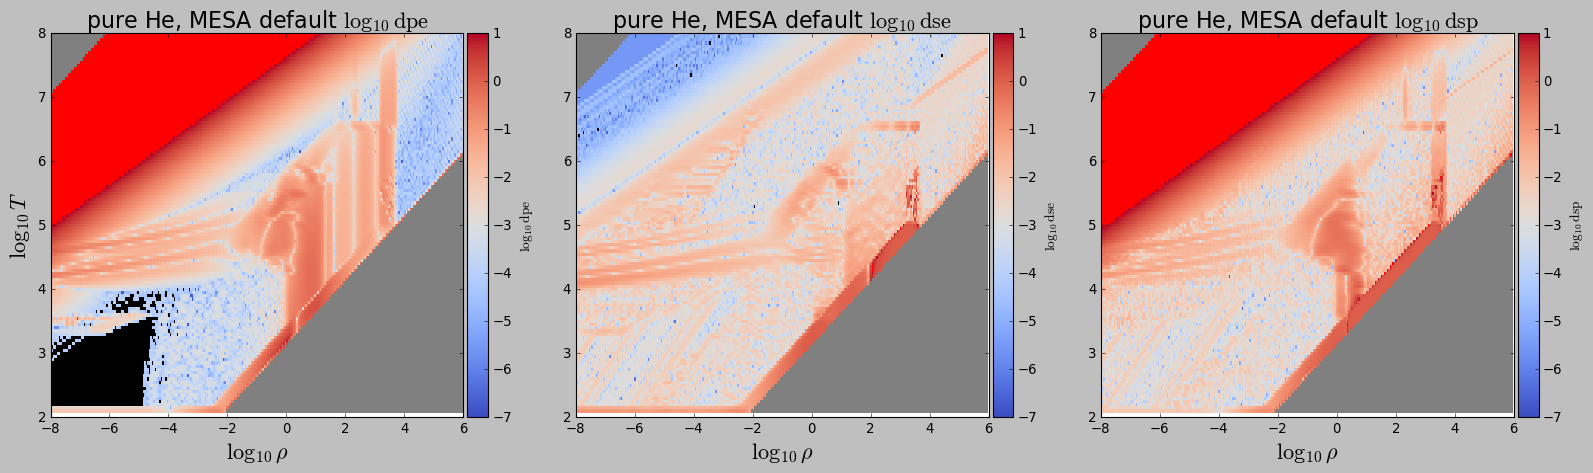

In [31]:
dpe, dse, dsp = consistency_metrics(mesaCMS_He_Trho,eosname='pure He, MESA-implemented CMS')
dpe, dse, dsp = consistency_metrics(my_He_Trho,eosname='pure He, my CMS')
dpe, dse, dsp = consistency_metrics(mesaDefault_He_resampled_Trho,eosname='pure He, MESA default')

## H/He mixture

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:129: RuntimeWarning: divide by zero encountered in divide
  dse = 10**rhoTgrid[:,:,0] * (dS_dT_rho/dE_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:130: RuntimeWarning: divide by zero encountered in divide
  dsp = -(10**rhoTgrid[:,:,-1])**2 * (dS_drho_T/dP_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:130: RuntimeWarning: invalid value encountered in divide
  dsp = -(10**rhoTgrid[:,:,-1])**2 * (dS_drho_T/dP_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))


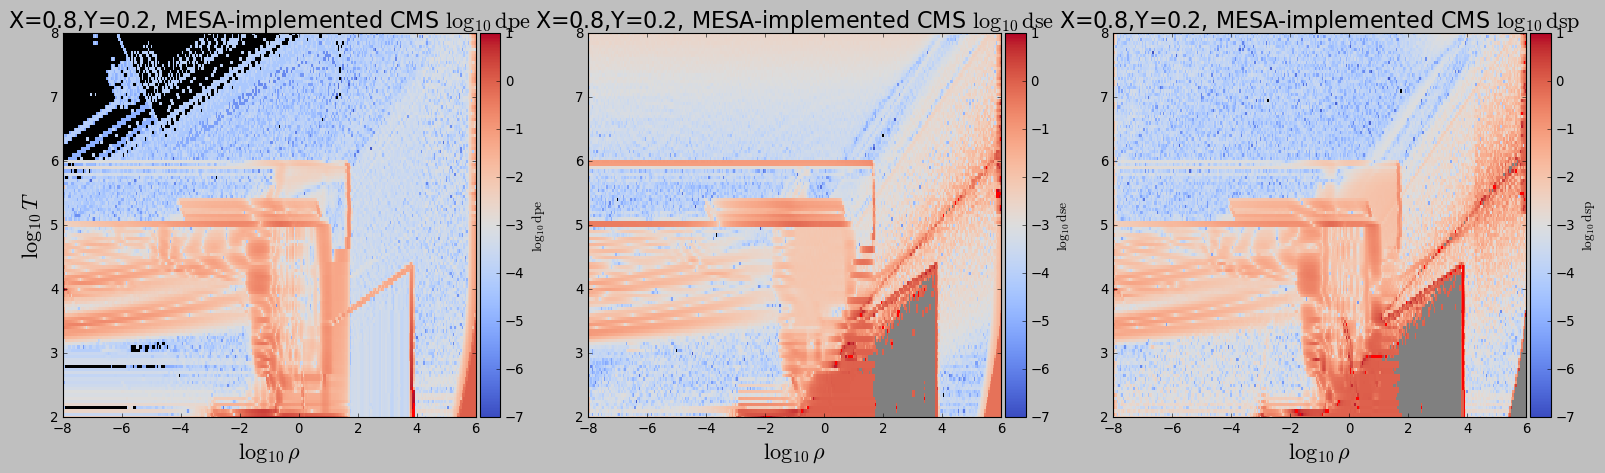

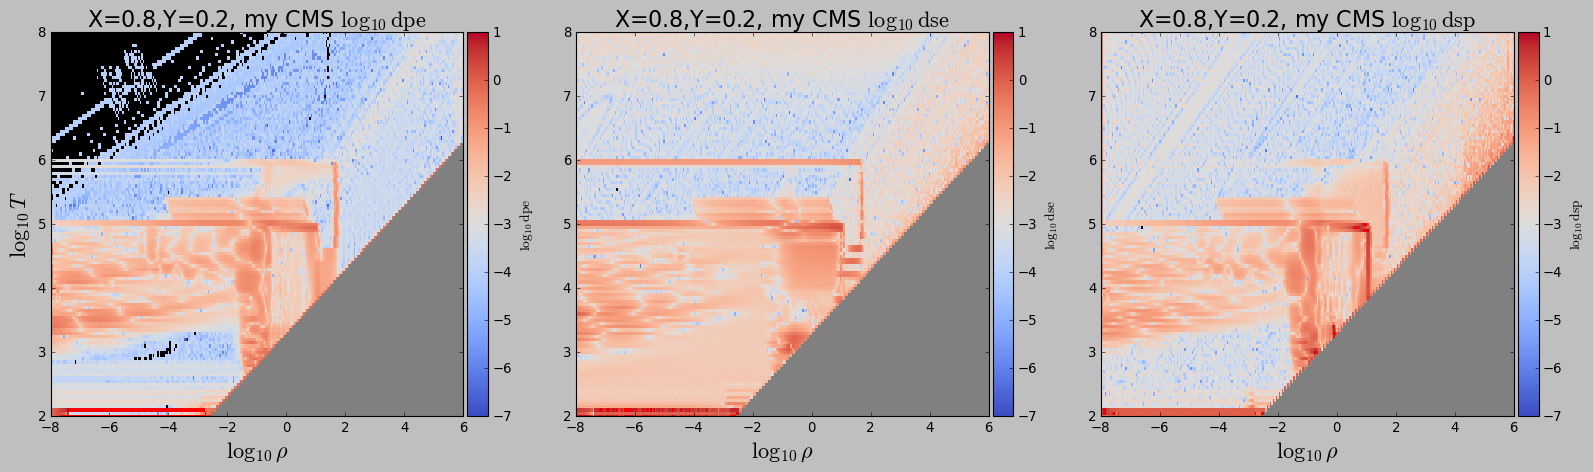

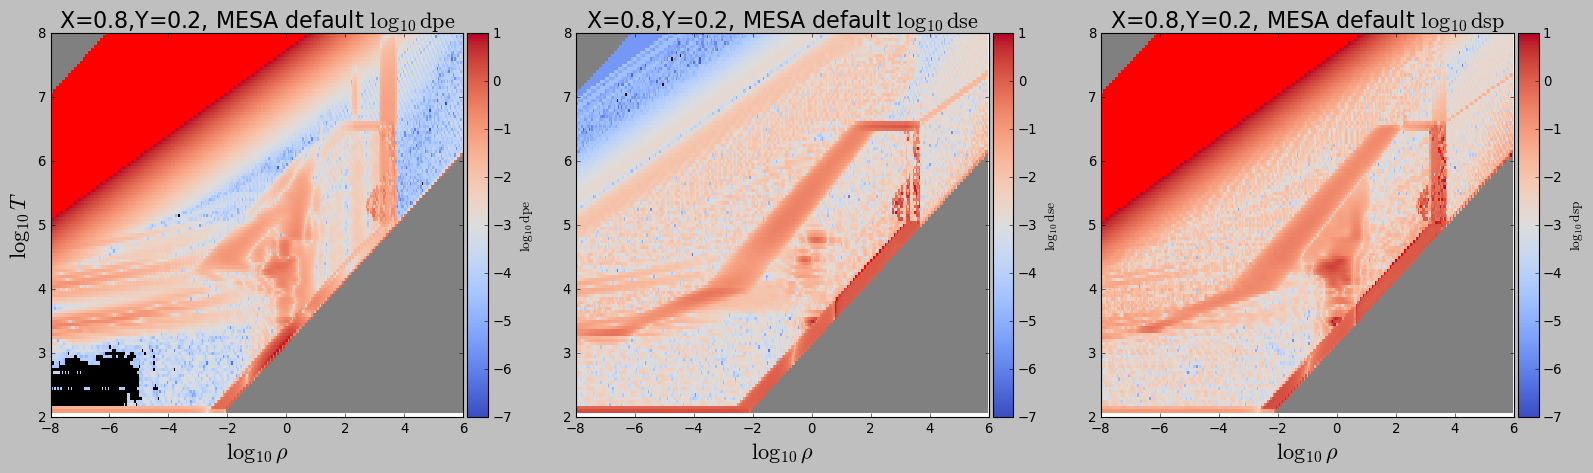

In [32]:
dpe, dse, dsp = consistency_metrics(mesaCMS_mixture_Trho,eosname='X=0.8,Y=0.2, MESA-implemented CMS')
dpe, dse, dsp = consistency_metrics(my_mixture_Trho,eosname='X=0.8,Y=0.2, my CMS')
dpe, dse, dsp = consistency_metrics(mesaDefault_mixture_resampled_Trho,eosname='X=0.8,Y=0.2, MESA default')

## Metals

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:129: RuntimeWarning: divide by zero encountered in divide
  dse = 10**rhoTgrid[:,:,0] * (dS_dT_rho/dE_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:130: RuntimeWarning: divide by zero encountered in divide
  dsp = -(10**rhoTgrid[:,:,-1])**2 * (dS_drho_T/dP_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))


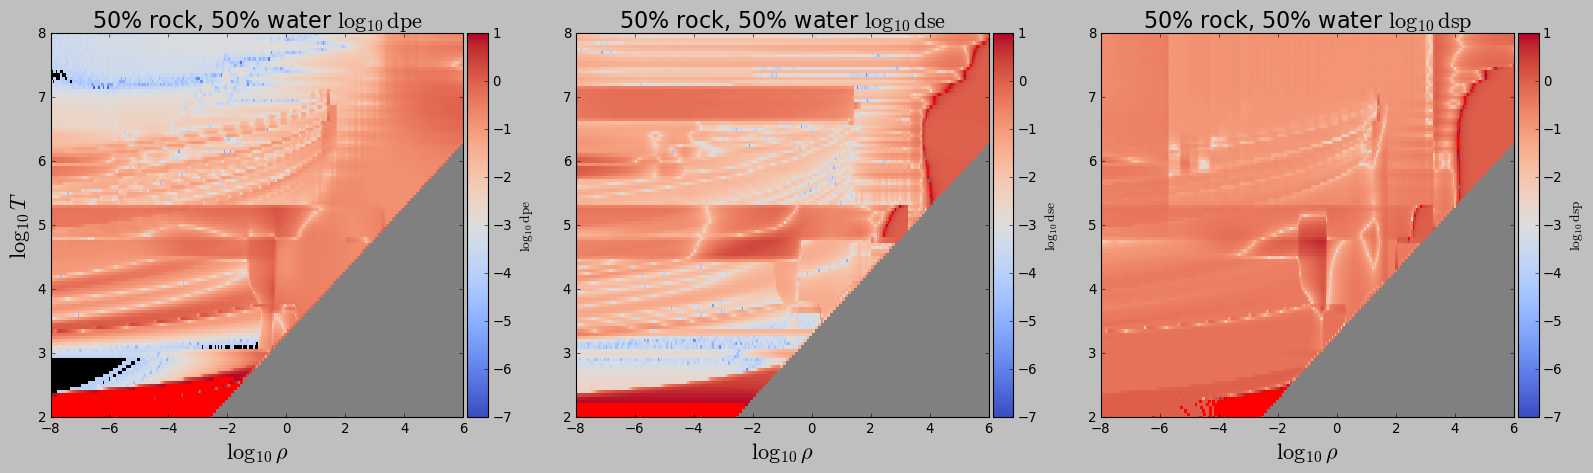

In [34]:
dpe, dse, dsp = consistency_metrics(my_Z_Trho,eosname='50% rock, 50% water')

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:129: RuntimeWarning: divide by zero encountered in divide
  dse = 10**rhoTgrid[:,:,0] * (dS_dT_rho/dE_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:130: RuntimeWarning: divide by zero encountered in divide
  dsp = -(10**rhoTgrid[:,:,-1])**2 * (dS_drho_T/dP_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:130: RuntimeWarning: invalid value encountered in divide
  dsp = -(10**rhoTgrid[:,:,-1])**2 * (dS_drho_T/dP_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))


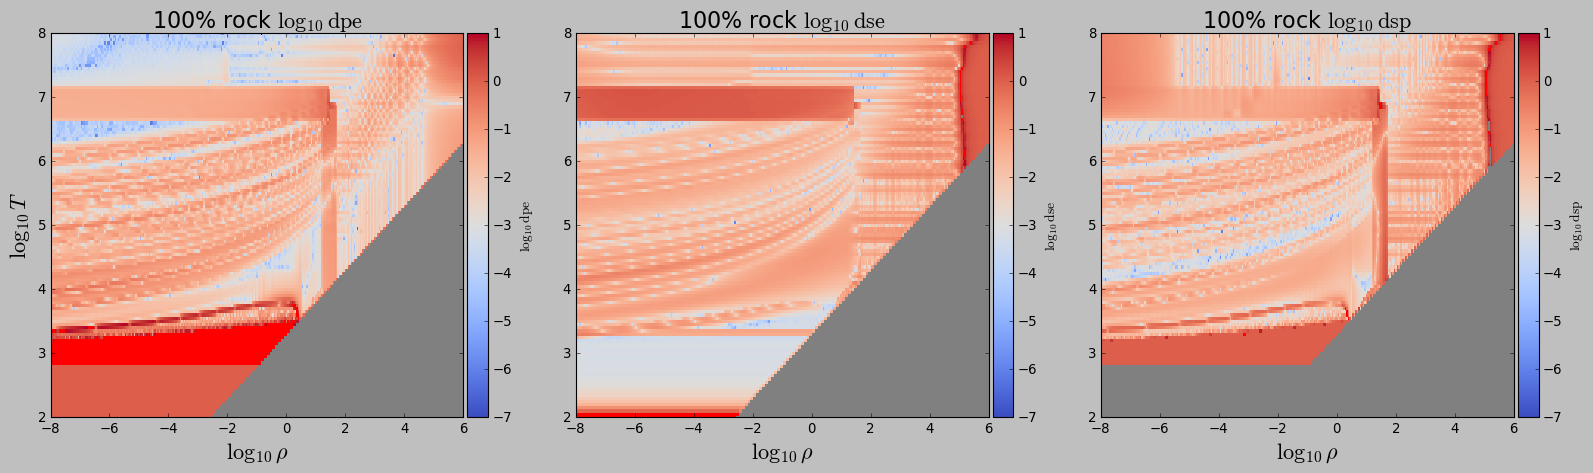

In [35]:
dpe, dse, dsp = consistency_metrics(rock_Trho,eosname='100% rock')

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:130: RuntimeWarning: divide by zero encountered in divide
  dsp = -(10**rhoTgrid[:,:,-1])**2 * (dS_drho_T/dP_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))


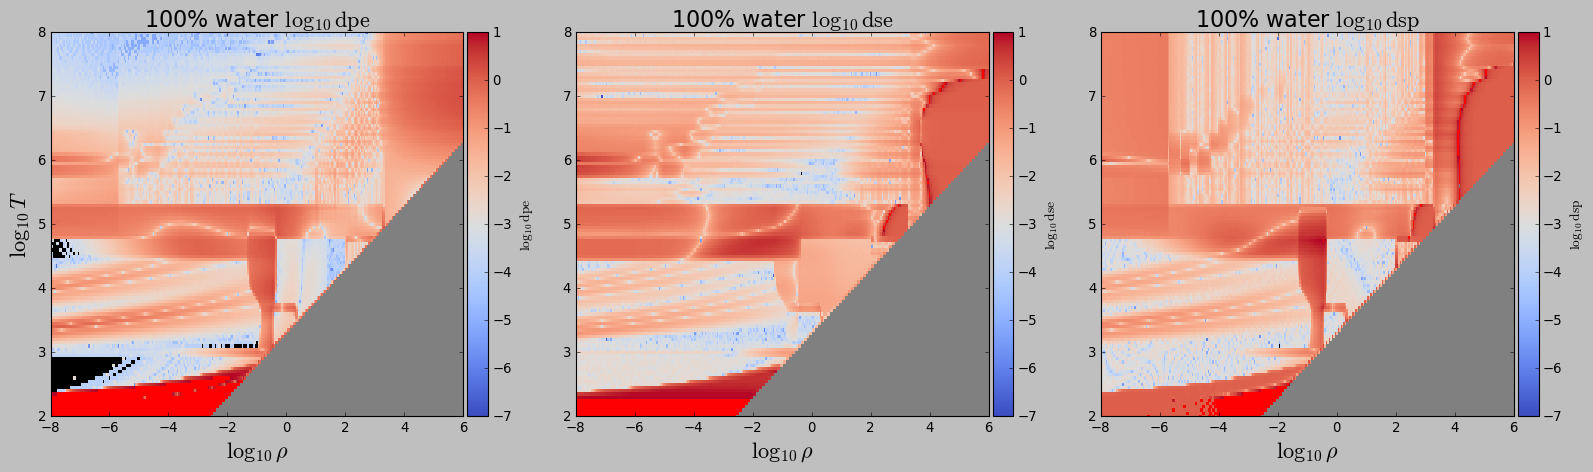

In [36]:
dpe, dse, dsp = consistency_metrics(h2o_Trho,eosname='100% water')

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:129: RuntimeWarning: divide by zero encountered in divide
  dse = 10**rhoTgrid[:,:,0] * (dS_dT_rho/dE_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:130: RuntimeWarning: divide by zero encountered in divide
  dsp = -(10**rhoTgrid[:,:,-1])**2 * (dS_drho_T/dP_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:130: RuntimeWarning: invalid value encountered in divide
  dsp = -(10**rhoTgrid[:,:,-1])**2 * (dS_drho_T/dP_dT_rho) - 1
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80591/1385950179.py:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))


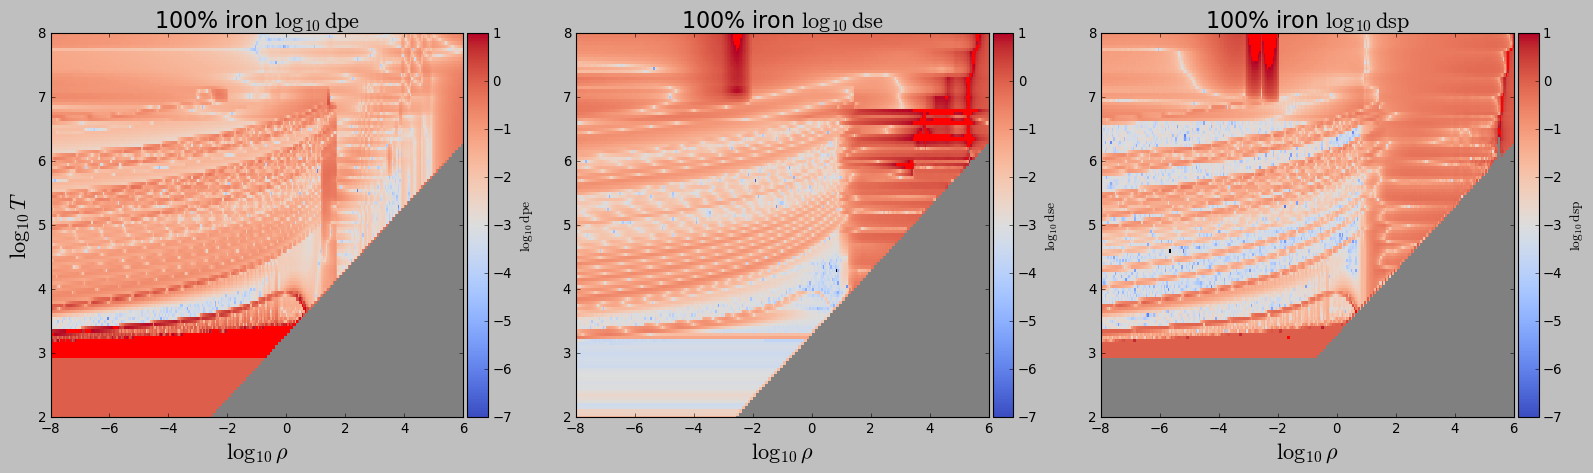

In [37]:
dpe, dse, dsp = consistency_metrics(iron_Trho,eosname='100% iron')